#네이버 쇼핑 리뷰 감성 분류하기
https://wikidocs.net/94600


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q tensorflow
import tensorflow as tf

***여기서는 형태소 분석기 Mecab을 사용합니다. 저자의 경우 Mecab을 편하게 사용하기 위해서 구글의 Colab을 사용하였습니다. 참고로 Colab에서 실습하는 경우가 아니라면 아래의 방법으로 Mecab이 설치되지 않습니다. 이 경우 해당 환경에 맞게 Mecab을 설치하시거나 다른 형태소 분석기를 사용하시기 바랍니다.

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 2.71 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-06-03 06:15:14--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::3403:4be7, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#from google.colab import files
#uploaded=files.upload()

In [ ]:
total_data = pd.read_excel('/content/drive/Shareddrives/종합설계/mssstylereviews-1000p.xlsx')

print('전체 리뷰 개수 :',len(total_data))

전체 리뷰 개수 : 3809


In [ ]:
total_data['label'] = np.select([total_data.ratings > 40], [1], default=0)
total_data[:5]

,product_id,product_name,sex,Height,Weight,ratings,url,reviews,Size,Bright,Color,Thick,src,src hyperlink,label
0,1.0,빅 포켓 집 풀오버 스트라이프 하프 셔츠_그레이,여성,177.0,82.0,100.0,https://www.musinsa.com//app/goods/1023970/0,출퇴근용으로 구매했는데 지퍼부분이 맘에 들어요,보통이에요,밝아요,선명해요,보통이에요,http://image.msscdn.net/data/estimate/1023970_...,http://image.msscdn.net/data/estimate/1023970_...,1
1,2.0,쿨코튼 2-PACK 베츠 기본 반팔 티셔츠 블랙/화이트,여성,158.0,53.0,100.0,https://www.musinsa.com//app/goods/1939099/0,백오십팔인 저에겐 큽니다.. 네.. 날씬해 보이고 그런 건 없네요. 무난하게 입기 ...,커요,보통이에요,선명해요,보통이에요,http://image.msscdn.net/data/estimate/1939099_...,http://image.msscdn.net/data/estimate/1939099_...,1
2,3.0,아트웍 오버 브이넥 니트조끼-그레이,남성,178.0,72.0,100.0,https://www.musinsa.com//app/goods/2121663/0,두껍지도 않고 얇은 두께감도 아닌 적당해요 한여름에는 실내에만 있다는 가정하에는 착...,보통이에요,보통이에요,보통이에요,보통이에요,http://image.msscdn.net/data/estimate/2121663_...,http://image.msscdn.net/data/estimate/2121663_...,1
3,4.0,투턱 와이드 슬랙스 [아이보리],남성,192.0,90.0,80.0,https://www.musinsa.com//app/goods/1832528/0,기장을 수선해지 않아도 될정도로 길어서 좋았어요 다리가 많이 긴편이라 거의 수선을 ...,커요,보통이에요,보통이에요,얇아요,http://image.msscdn.net/data/estimate/1832528_...,http://image.msscdn.net/data/estimate/1832528_...,1
4,5.0,(22SS) EMBROIDERY UNIVERSITY DAN TEE WHITE,여성,160.0,52.0,100.0,https://www.musinsa.com//app/goods/1886950/0,목 넓지 않은 것 찾아보다 구매했는데 편하고 딱 맞아요!! 굳굳,보통이에요,보통이에요,보통이에요,보통이에요,http://image.msscdn.net/data/estimate/1886950_...,http://image.msscdn.net/data/estimate/1886950_...,1


In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(5, 3610, 2)

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 3610


In [ ]:
print(total_data.isnull().values.any())

False


In [ ]:
#네이버 쇼핑 리뷰로 훈련 시키고 무신사 리뷰로 테스트해보기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
train_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
train_data['label'] = np.select([train_data.ratings > 3], [1], default=0)
train_data.drop_duplicates(subset=['reviews'], inplace=True)
test_data=total_data[:]
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 199908
테스트용 리뷰의 개수 : 3610


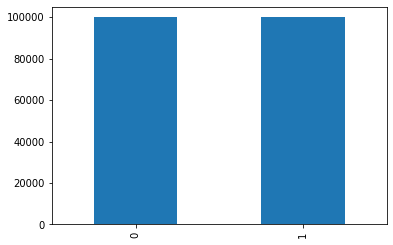

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  99955
1      1  99953


In [ ]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


ratings    0
reviews    0
label      0
dtype: int64


데이터 정제하기

In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='all') # Null 값 제거

print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 3610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  



토큰화





In [ ]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

단어와 길이 분포 확인하기

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 42378), ('는데', 27052), ('안', 26316), ('어요', 19751), ('너무', 17622), ('있', 17522), ('했', 15611), ('좋', 13011), ('배송', 12873), ('같', 11980), ('거', 11786), ('어', 11777), ('구매', 11743), ('없', 11609), ('아요', 11604), ('되', 11270), ('습니다', 11256), ('그냥', 11154), ('잘', 10755), ('않', 10610)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 52741), ('아요', 28159), ('네요', 26526), ('잘', 24803), ('어요', 24773), ('구매', 21598), ('습니다', 17985), ('있', 16511), ('배송', 16319), ('는데', 15579), ('합니다', 13048), ('했', 13046), ('먹', 12841), ('재', 12434), ('너무', 11230), ('같', 10483), ('만족', 9726), ('거', 8712), ('어', 8442), ('쓰', 8403)]


긍정 리뷰의 평균 길이 : 13.594369353596191
부정 리뷰의 평균 길이 : 17.03308488819969


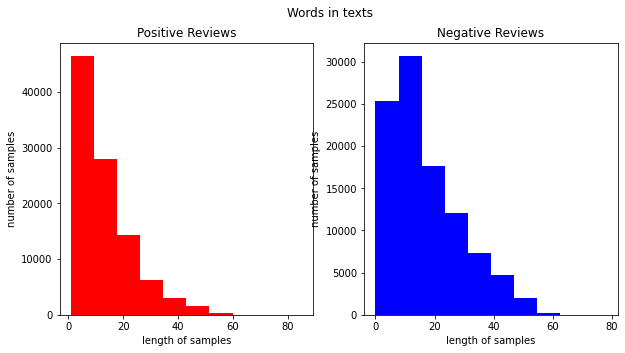

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45657
등장 빈도가 1번 이하인 희귀 단어의 수: 20835
단어 집합에서 희귀 단어의 비율: 45.63374728957225
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.680584319285019


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 24824


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

패딩

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.313744322388299


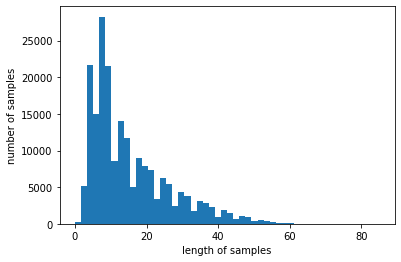

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len =80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.9989995397883


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#GPU로 네이버 쇼핑 리뷰 감성 분류하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
2498/2499 [============================>.] - ETA: 0s - loss: 0.2602 - acc: 0.9025
Epoch 1: val_acc improved from -inf to 0.92011, saving model to best_model.h5
2499/2499 [==============================] - 32s 10ms/step - loss: 0.2602 - acc: 0.9025 - val_loss: 0.2202 - val_acc: 0.9201
Epoch 2/15
2495/2499 [============================>.] - ETA: 0s - loss: 0.2073 - acc: 0.9254
Epoch 2: val_acc improved from 0.92011 to 0.92499, saving model to best_model.h5
2499/2499 [==============================] - 24s 10ms/step - loss: 0.2072 - acc: 0.9254 - val_loss: 0.2121 - val_acc: 0.9250
Epoch 3/15
2496/2499 [============================>.] - ETA: 0s - loss: 0.1934 - acc: 0.9315
Epoch 3: val_acc improved from 0.92499 to 0.92649, saving model to best_model.h5
2499/2499 [==============================] - 25s 10ms/step - loss: 0.1934 - acc: 0.9315 - val_loss: 0.2073 - val_acc: 0.9265
Epoch 4/15
2496/2499 [============================>.] - ETA: 0s - loss: 0.1840 - acc: 0.9351
Epoch 4: val_

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

113/113 [==============================] - 1s 5ms/step - loss: 0.1884 - acc: 0.9238

 테스트 정확도: 0.9238


#리뷰 예측해보기

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    return("{:.2f}% 긍정".format(score * 100))
  else:
    return("{:.2f}% 부정".format((1 - score) * 100))

In [ ]:
A=(sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박'))
A

'97.89% 긍정'

In [ ]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

'99.61% 부정'

In [ ]:
sentiment_predict('그렇게 편한 착용감은 아니였어요 그러나 색감은 정말 ~ 예쁩니다 ㅎㅎ')

'96.60% 긍정'

엑셀에 정리하기

In [ ]:
#데이터 불러오기
convert=pd.read_excel("/content/drive/Shareddrives/종합설계/data/5 20-30.xlsx",usecols="A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P")

#감정분석
for x in range(len(convert)):
  R=convert.iloc[x]['comment']
  S=sentiment_predict(R)
  convert.loc[x,'sentiment']=S

convert['sentiment_percentage'] = convert.sentiment.str.split(' ').str[0:1]
convert['sentiment_predict'] = convert.sentiment.str.split(' ').str[1:2]
convert.to_excel("/content/drive/Shareddrives/종합설계/data/5 20-30.xlsx")

/usr/local/lib/python3.7/dist-packages/pandas/io/excel/_base.py:1292: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  **kwds,
